# **Deep learning entry task**
 <img src="https://www.tu-braunschweig.de/typo3conf/ext/tu_braunschweig/Resources/Public/Images/Logos/tu_braunschweig_logo.svg" align="right" width="200px"/>

[Institute of Geodesy and Photogrammetry](https://www.tu-braunschweig.de/en/igp),  
[The Technical University of Braunschweig  ](https://www.tu-braunschweig.de/en/)  
Instructors: [Dr. -Ing. Mehdi Maboudi](https://www.tu-braunschweig.de/en/igp/staff/mehdi-maboudi) and [Dr. Pedro Achanccaray](https://www.tu-braunschweig.de/en/igp/staff/pedro-diaz)
<br clear="left"/>

The purpose of this entry task is to measure your **knowledge of machine learning and artificial neural network concepts**. You should be familiar with these topics for **better understanding and comprehension** of the deep learning course.


For this reason, the entry task should be solved **without using any artificial intelligence tools** (ChatGPT, Copilot, among others). You can only use them to assist you in **debugging** your code.

# **1. Import all necessary packages**

In [2]:
import torch
from torch import no_grad
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split



# **2. Load the Fashion MNIST dataset for image classification**

- Load the Fashion MNIST dataset.
- Create three disjoint sets: train, validation and test (you can use any proportions for these sets).

In [3]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,) )])

train_set = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# train_set.data = train_set.data.float() / 255.0
# test_set.data = test_set.data.float() / 255.0                        
#Normalizing to [0, 1] might not fully utilize the entire dynamic range of pixel values, potentially losing some information during normalization.
#Therefore, we normalizes the pixel values of images to have a mean of 0 and a standard deviation of 1.

print(train_set)  
print(test_set)

train_size = int(0.80 * len(train_set))
val_size = len(train_set) - train_size
train_set, val_set = torch.utils.data.random_split(train_set, [train_size, val_size])

print("after validation split","\n train set", len(train_set))  
print("val set", len(val_set)) 

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)


Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
after validation split 
 train set 48000
val set 12000


In your own words, describe the purpose of each set:
- _train_:
- _validation_:
- _test_:

## Training set:
- This set is used to train the machine learning model. Here we have 51000 training samples.
- During training, the model learns the underlying pattern, so that it can minimize the loss function and generalize on unseen data.

## Validation set:
- This set is  used to tune hyperparameters and evaluate performance during training. Used to detect overfitting and underfitting. 
- Test set should be kept completely separate from the training process and only used once to assess the final model's performance on unseen data. Therefore the validation set is usually taken from training set. 
- This is also called as developmenet set or hold-out set. 

## Test set: 
- This set is a seperate set used to evaluate the final performance of the model in real time, once the model is completely trained.
- Hyperparameter tuning or training of the model should not be done on the test set. I used to calculate the test accuracy, measure of generalisation. 

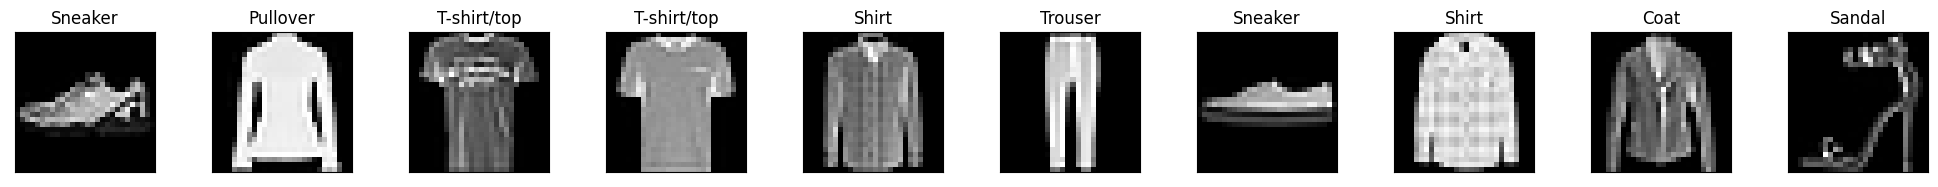

In [4]:

label_dict={0:'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',5:'Sandal',6:'Shirt',7:'Sneaker',8:'Bag',9:'Ankle boot'}

images,labels=next(iter(train_loader))
fig=plt.figure(figsize=(25,4))
for i in range(1,11):
    ax=fig.add_subplot(2,10,i,xticks=[],yticks=[])
    ax.imshow(images[i].view(28,28),cmap='gray')
    ax.set_title(str(label_dict[labels[i].item()]))

# **3. Create a Multi Layer Perceptron (MLP) for image classification**


Feel free to use any configuration (number of hidden layers, number of neurons per layer) and framework (Scikit learn, Keras, TensorFlow, PyTorch, etc.)

In [6]:
#initially made the model with one hidden layer with no droupout.
# during hyperparameter tuning, i added extra hidden layer with dropout and changed the number of neurons
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.ReLU(),    
            nn.Dropout(p=0.2),
            nn.Linear(256, 128),
            nn.ReLU(),     # zero for -ve inputs and the input itself for +ve inputs
            nn.Dropout(p=0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(64,10)
        )
    def forward(self, x):
        x = self.layers(x)  
        return x  
    
mlp = SimpleMLP()
print("Model:\n", mlp)
 

Model:
 SimpleMLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=128, out_features=64, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.2, inplace=False)
    (10): Linear(in_features=64, out_features=10, bias=True)
  )
)


# **4. Train the model**

Train the model and perform a hyperparameter tuning to find the best learning rate from a set of learning rates (1D grid search).

In [7]:
# CrossEntropyLoss is a popular choice for classification tasks.
criterion = nn.CrossEntropyLoss()


def train_model(model, train_loader, val_loader, learning_rate,optimizer_type, epochs):

    # Trained the model with SGD and Adam, Adam gave good results. 
    optimizer = optimizer_type(model.parameters(), lr=learning_rate)
    
    train_losses = []
    val_losses = []

    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        
            running_loss += loss.item()
            predicted = torch.argmax(outputs, 1)

            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            loss.backward()
            optimizer.step()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                outputs = model(val_inputs)
                loss = criterion(outputs, val_labels)
                running_loss += loss.item()
                predicted = torch.argmax(outputs, 1)
                total_val += val_labels.size(0)
                correct_val += (predicted == val_labels).sum().item()

        val_loss = running_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies


# Perform hyperparameter tuning
# Trained the model with  different learning rates to see if it improves performance and found 0.001 to be the best one.

# learning_rates =  [0.001,0.01,0.1]                          
learning_rates =  [0.001]                           
optimizer_types = [optim.Adam]                      #optimizer  = [optim.SGD , optim.Adam]

best_val_accuracy = 0
best_learning_rate = None
best_optimizer = None
best_model = None

# training for various learning rate and optimizer
for opt in optimizer_types:
    print("Optimizer used is \n", opt)
    for lr in learning_rates:
        print("Learning rate used is \n", lr)
        model = SimpleMLP()
        train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader,  lr,opt,epochs=30)
       

        # Select the best model based on high validation accuracy
        if val_accuracies[-1] > best_val_accuracy:
            best_val_accuracy = val_accuracies[-1]
            best_learning_rate = lr
            best_optimizer = opt
            best_model = model
print("best val accuracy",best_val_accuracy)
print("best learning_rate",best_learning_rate)
print("best optimizer", best_optimizer)
print("best model",best_model)



Optimizer used is 
 <class 'torch.optim.adam.Adam'>
Learning rate used is 
 0.001
Epoch 1/30, Train Loss: 0.6264, Train Acc: 0.7741, Val Loss: 0.4250, Val Acc: 0.8432
Epoch 2/30, Train Loss: 0.4501, Train Acc: 0.8397, Val Loss: 0.3918, Val Acc: 0.8574
Epoch 3/30, Train Loss: 0.4088, Train Acc: 0.8538, Val Loss: 0.3696, Val Acc: 0.8636
Epoch 4/30, Train Loss: 0.3849, Train Acc: 0.8626, Val Loss: 0.3512, Val Acc: 0.8724
Epoch 5/30, Train Loss: 0.3650, Train Acc: 0.8696, Val Loss: 0.3405, Val Acc: 0.8725
Epoch 6/30, Train Loss: 0.3518, Train Acc: 0.8731, Val Loss: 0.3406, Val Acc: 0.8720
Epoch 7/30, Train Loss: 0.3417, Train Acc: 0.8781, Val Loss: 0.3303, Val Acc: 0.8746
Epoch 8/30, Train Loss: 0.3297, Train Acc: 0.8819, Val Loss: 0.3337, Val Acc: 0.8742
Epoch 9/30, Train Loss: 0.3195, Train Acc: 0.8855, Val Loss: 0.3248, Val Acc: 0.8807
Epoch 10/30, Train Loss: 0.3106, Train Acc: 0.8890, Val Loss: 0.3209, Val Acc: 0.8818
Epoch 11/30, Train Loss: 0.3034, Train Acc: 0.8888, Val Loss: 0.337

# **5. Plots**

Plot the evolution of the Loss function and Accuracy values over the epochs (for train and validation sets) during training the best model.

- What can you infere from the training curves of the model? 
- Is there over- or underfitting?

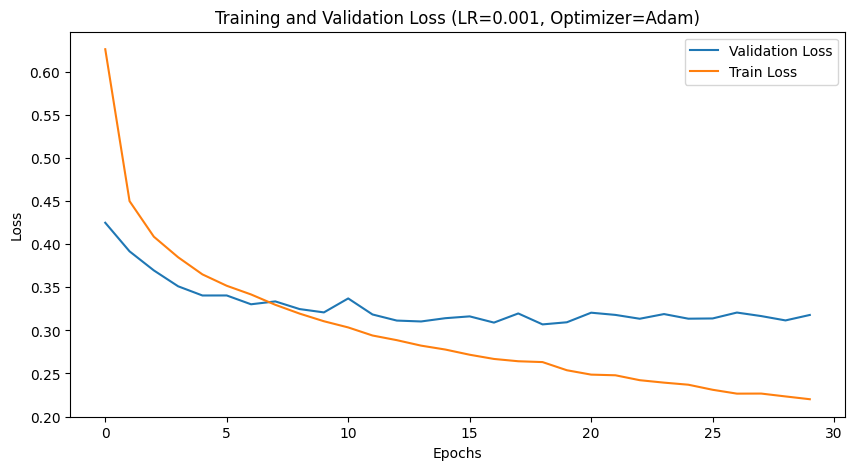

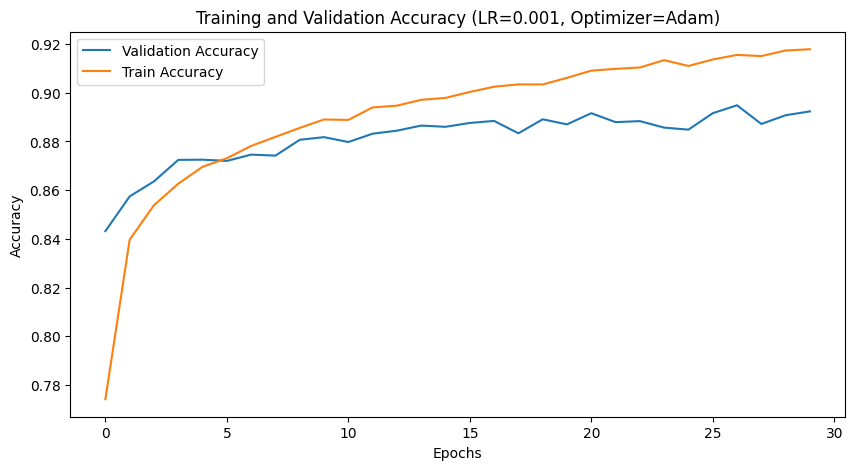

In [8]:
# model = SimpleMLP()
# train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader,  lr,opt,epochs=30)



# Plot training and validation loss for the best model selected
plt.figure(figsize=(10, 5))
plt.plot(val_losses, label='Validation Loss')
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training and Validation Loss (LR={lr}, Optimizer={opt.__name__})')
plt.legend()
plt.show()

# Plot training and validation accuracy  for the best model selected
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.plot(train_accuracies, label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title(f'Training and Validation Accuracy (LR={lr}, Optimizer={opt.__name__})')
plt.legend()
plt.show()

## NOTES
### Initially i ran training model with following neural network architecture and settings:

  - two hidden layers with relu activation, but with no regularization (dropout).  (Even before this i used only one hidden layer)
  - epoch = 250
  - loss function = Cross entropy loss
  - optimizer = Adam
  - learning rate = 0.001

Then i acheived the plot below, which shows overfitting. This model performs much worse than the final model. 

  ![250 Epoch.jpg](<attachment:250 Epoch.jpg>) 


#### In order to prevent overfitting i did the following, 
 - used dropout  (one of regularization techniques)
 - early stopped used, i ran only till 30 epoch. (another regularization techniques)
 - change the number of neurons in each layer and added one extra hidden layer

 After making these changes we are still able to see there's overfitting after the range of 5 - 10

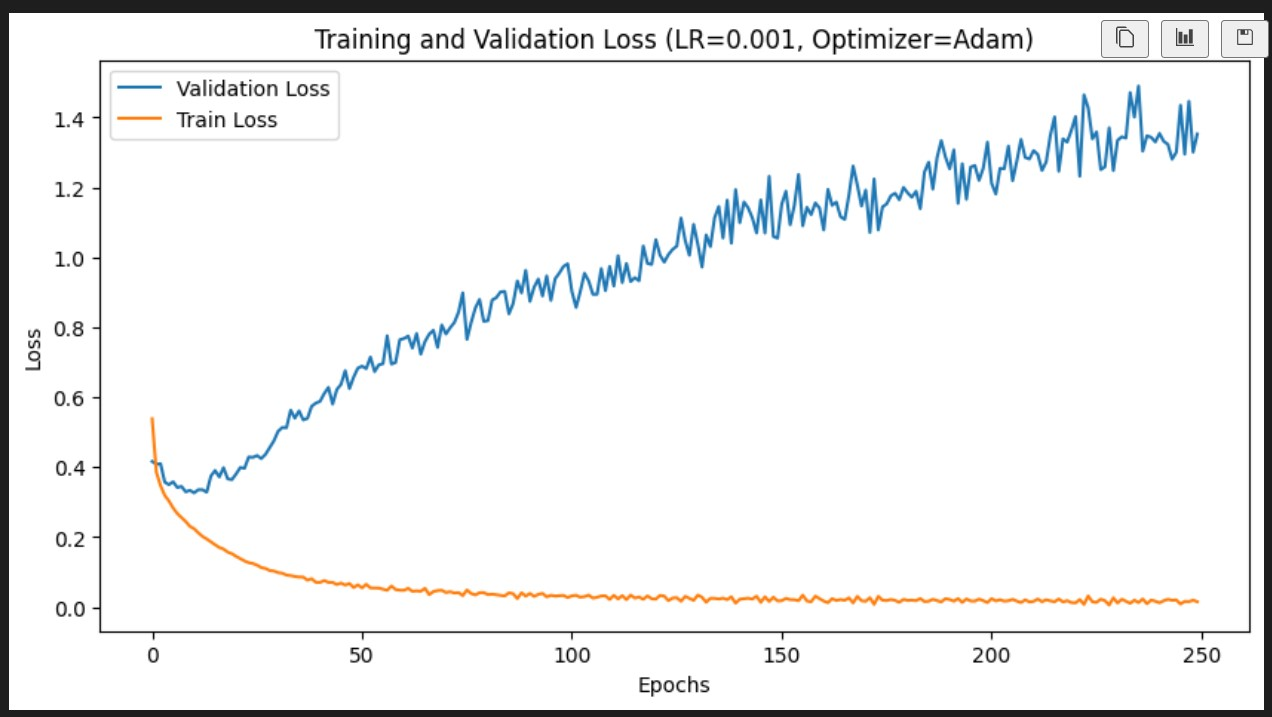

# **6. Inference**
Run inference in the test set and compute the metrics for testing.

In [12]:
def test_model(model, test_loader):
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for test_inputs, test_labels in test_loader:
            outputs = model(test_inputs)
            predicted = torch.argmax(outputs, 1)
            test_total += test_labels.size(0)
            test_correct += (predicted == test_labels).sum().item()
    accuracy = test_correct / test_total
    print(f"Test Accuracy: {accuracy:.4f}")

test_model(best_model, test_loader)

Test Accuracy: 0.8834


Test Accuracy: 0.8834


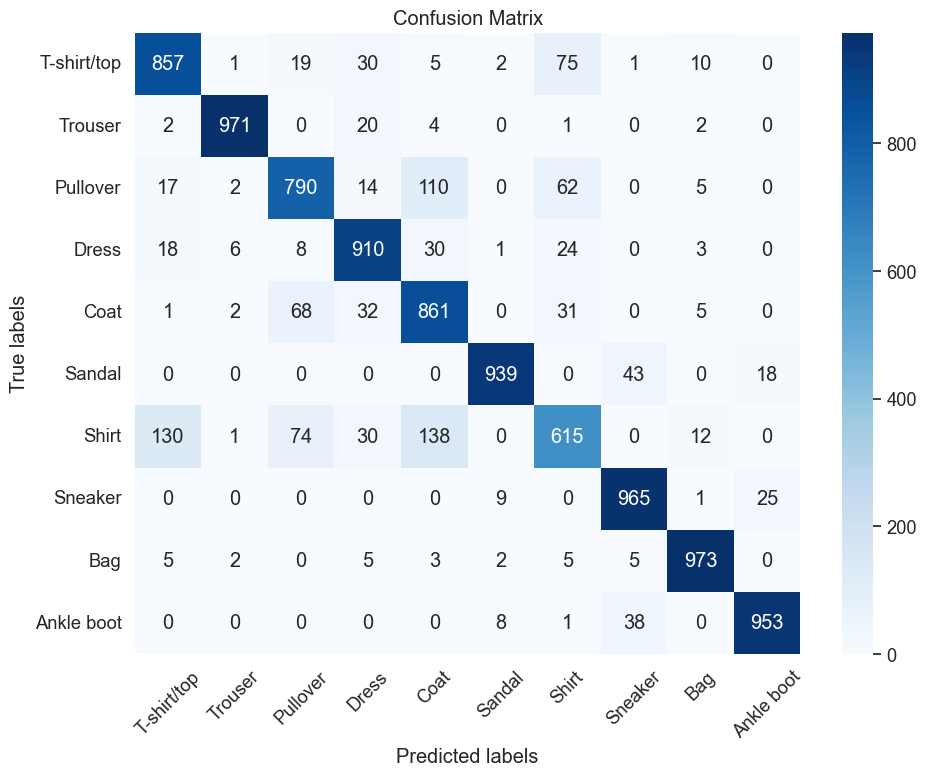

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def test_model_with_confusion_matrix(model, test_loader, classes):
    model.eval()
    test_correct = 0
    test_total = 0
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for test_inputs, test_labels in test_loader:
            outputs = model(test_inputs)
            predicted = torch.argmax(outputs, 1)
            test_total += test_labels.size(0)
            test_correct += (predicted == test_labels).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(test_labels.cpu().numpy())

    accuracy = test_correct / test_total
    print(f"Test Accuracy: {accuracy:.4f}")

    # Calculate confusion matrix
    cm = confusion_matrix(all_targets, all_predictions)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    # Save confusion matrix as an image
    plt.savefig('confusion_matrix.png', dpi=300)
    plt.show()

# Define the classes for FashionMNIST dataset
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Call the function to test the model and generate confusion matrix
test_model_with_confusion_matrix(best_model, test_loader, classes)


# **7. Test samples**

Show some samples from the test set. Use the following layout: input image, reference class and predicted class.

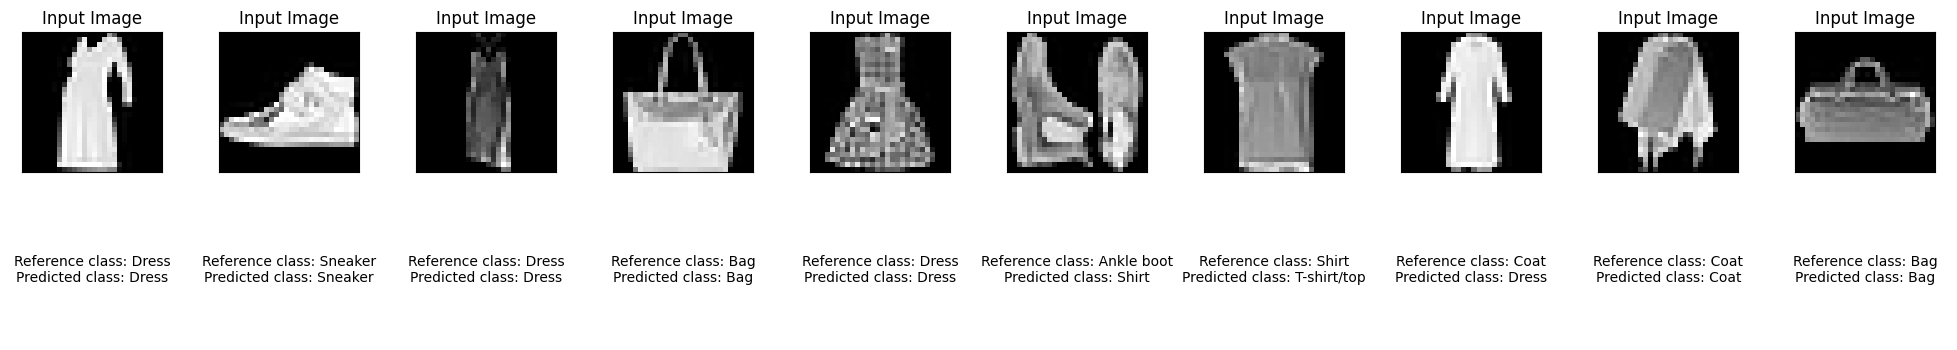

In [16]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=10, shuffle=True)

fig = plt.figure(figsize=(25, 4))

best_model.eval()

with torch.no_grad():
    test_images, test_labels = next(iter(test_loader))   
    for i in range(10):
        # shape = test_images[i].shape
        # print(shape)
        inputs = test_images[i].unsqueeze(0) 
        output = best_model(inputs)  
        predicted_class = torch.argmax(output, 1).item()
        
        ax = fig.add_subplot(2, 10, i + 1, xticks=[], yticks=[])
        ax.imshow(test_images[i].view(28, 28), cmap='gray')
        ax.set_title('Input Image')
        
        ax = fig.add_subplot(2, 10, i + 11)
        ax.text(0.5, 0.5, f'Reference class: {label_dict[test_labels[i].item()]}\nPredicted class: {label_dict[predicted_class]}', 
                horizontalalignment='center', verticalalignment='center')
        ax.axis('off')

# **8. Testing with new images**


Test the model with at least two images (from internet or take a photo with your phone or camera). 

Do not forget to convert the image to the Fashion MNIST format: grayscale, $28\times 28$, apply normalization, etc. 

Comment the results.

Image size: torch.Size([1, 28, 28])
Original designator is dress


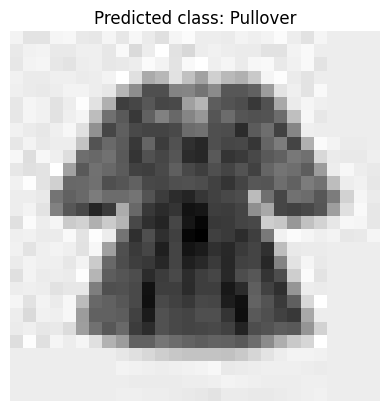

Image size: torch.Size([1, 28, 28])
Original designator is sneaker


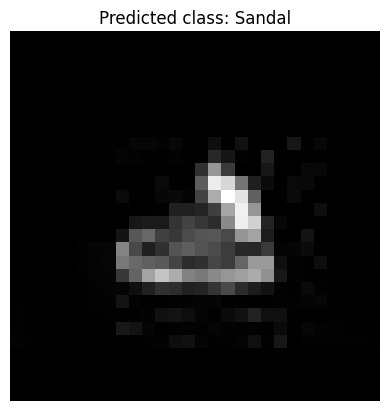

Image size: torch.Size([1, 28, 28])
Original designator is sneaker


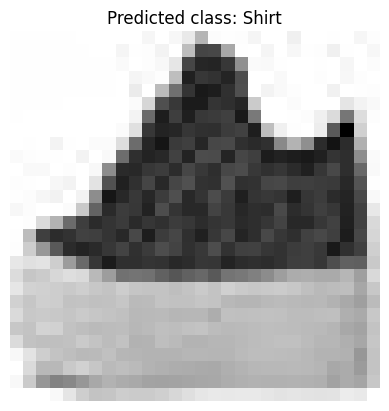

In [17]:
from PIL import Image

custom_transform = transforms.Compose([
    transforms.Resize((28, 28)),                       
    transforms.Grayscale(num_output_channels=1),      
    transforms.ToTensor(),     
    transforms.Normalize((0.5,),(0.5,) )                          
])

def predict_image(image_path, best_model):
    image = Image.open(image_path)
    image = custom_transform(image)
    shape = image.shape
    print(f"Image size: {shape}")

    best_model.eval()
    with torch.no_grad():
        inputs = image.unsqueeze(0)
        output = best_model(inputs)
    
        predicted = torch.argmax(output, 1).item()
        return label_dict[predicted], image.squeeze().numpy()

# image1 = 'dress.jpg'
# image2 = 'black shoe.jpg'
image_list =  ['dress.jpg','black shoe.jpg','shoe.jpg']
image_label = ['dress', 'sneaker', 'sneaker']

for i, image_path in enumerate(image_list):
    prediction, image_data = predict_image(image_path, best_model)
    print("Original designator is", image_label[i])
    plt.imshow(image_data, cmap='gray')
    plt.title(f'Predicted class: {prediction}')
    plt.axis('off')
    plt.show()

### COMMENTS

In realtime world images, the model is not performing well, despite having a reasonably high test accuracy on the mnist dataset. This would be the following reasons,

- real time images contains noise and are not well centered as fashion Mnist dataset
- fashion mnist dataset has done some thresholding so that the background is black and only the items are visible. When we try to give a new image with different background and noise, the model learns it as well. That's why it's finding it hard to generalize with MLP model 
- the preprocessing of the unseen image doesn't resemble the training dataset
- the distribution is unknown
- mnist is limited training data when compared to unknown
- my model is also overfitting to the given dataset, which will lead to poor generalization and it memorizes

# **9. How could we improve the trained model?**

Share your ideas and comments to further improve the results.



### In order to improve the results, we can do the following:

- use deeper architectures with more layers and more neurons per layer. That is increase the depth and width of the network
- use different activation functions other than ReLu
- we can use data augmentation, L1 / L2 regularization and other regularization Techniques
- do even more work in hyperparameter tuning
- pre-process the realtime data in order to resemble the training dataset or work and improving the training dataset
- use pretrained models which are trained on large, sophisticated datasets when compared to Mnist
- do some error analysis
- perform some tradeoff based on how you want the model to be

##### Note
- I used the help of chatgpt for creating the plotting functions and some time for debugging. For the model, i either used official documentations, my notes and other online resources.